<a href="https://colab.research.google.com/github/algo74/MLCourse/blob/master/HW3/HW3_Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing heatmaps of class activation

This is based on `visualize_heatmaps_of_class_activation.ipynb` and Problem 2

The weights for the model are from `HW3_Problem2_fulltraining`

In [0]:
import keras

## Mount Google Drive

I used Google Drive in Problems 1 and 2 and here initially.

I rewrote the code to `wget` the model from my personal website. 

Unfortunately, the model is too big to `wget` through a sharable link from Google Drive

In [0]:
## Code to use Google Drive

# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# file_prefix = '/gdrive/My Drive/HW3/'

## Alternative code - from my website

!mkdir /saved_models
!wget --no-check-certificate \
  "http://agoponenko.ga/saved_models/Problem2_fulltake6.h5" \
  -O /saved_models/Problem2_fulltake6.h5
file_prefix = '/saved_models/'

mkdir: cannot create directory ‘/saved_models’: File exists
--2019-04-18 22:25:28--  http://agoponenko.ga/saved_models/Problem2_fulltake6.h5
Resolving agoponenko.ga (agoponenko.ga)... 198.91.81.3
Connecting to agoponenko.ga (agoponenko.ga)|198.91.81.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177051856 (169M)
Saving to: ‘/saved_models/Problem2_fulltake6.h5’

/saved_models/Probl 100%[===================>] 168.85M  15.0MB/s    in 16s     

2019-04-18 22:25:45 (10.4 MB/s) - ‘/saved_models/Problem2_fulltake6.h5’ saved [177051856/177051856]



## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 22:25:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  81.0MB/s    in 0.8s    

2019-04-18 22:25:49 (81.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Prepare image generator

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    shuffle=False,
    class_mode='binary')



Found 1000 images belonging to 2 classes.


## Build the model

Unfortunately, `K.gradients` did not work with the original model. I had to rebuild the model and then set its weights from the old model (otherwise I would have to redo Problems 1 & 2). I also had to remove the sigmoid activation for the last neuron.


### Load the saved model

In [0]:
file_name = file_prefix + 'Problem2_fulltake6.h5'
old_model = keras.models.load_model(file_name)
old_conv_base = old_model.layers[0]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Rebuilding model

In [0]:
# https://github.com/keras-team/keras/issues/10716

from keras import models, layers
from keras.applications import VGG19

inp = layers.Input([150, 150, 3])
conv_base = VGG19(include_top=False,
                  input_tensor=inp)
x = layers.Flatten()(conv_base.get_output_at(-1))
x = layers.Dense(256, name="dense_1", activation="relu")(x)
x = layers.Dense(1, name="dense_2")(x)
model = models.Model(inp,x)

# reloading weights
model.load_weights(file_name, by_name=True)
# unfortunately, the code above didn't set weights for the VGG19 part
conv_base.set_weights(old_conv_base.get_weights())
#conv_base.load_weights(file_name, by_name=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Calculating "confusion" classes

In [0]:
results = model.predict_generator(validation_generator, steps=50)
classes = validation_generator.classes

In [0]:
real_dogs = [i for i in range(1000) if (classes[i] == 1 and results[i] > 0)]
real_cats = [i for i in range(1000) if (classes[i] == 0 and results[i] < 0)]
fake_dogs = [i for i in range(1000) if (classes[i] == 0 and results[i] > 0)]
fake_cats = [i for i in range(1000) if (classes[i] == 1 and results[i] < 0)]

In [0]:
print(len(real_cats), len(fake_cats))
print(len(fake_dogs), len(real_dogs))

486 8
14 492


## Preparing visualization

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image


filenames = validation_generator.filenames

last_conv_layer = conv_base.get_layer('block5_conv4')



def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  cv2_imshow(superimposed_img)

In [0]:
def process_image(img_path):
  img = image.load_img(img_path, target_size=(150, 150))
  #
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  #
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #
  preds = model.predict(x)
  print('Predicted:', preds[0])
  
    
  class_output = model.output[:, 0]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  min = np.min(heatmap)
  max = np.max(heatmap)
  heatmap -= np.min(heatmap)
  heatmap /= max-min

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  #
  show_superimposed_image(img_path, heatmap)
  
def my_process_image(name):
  print(name)
  img_path = os.path.join(validation_dir, name)
  return process_image(img_path)

## Visualization

**RED is DOG**

**BLUE is CAT**

### A real cat  (properly classified)

cats/cat.2000.jpg


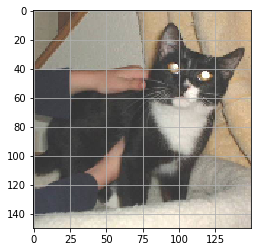

Predicted: [-72.31194]


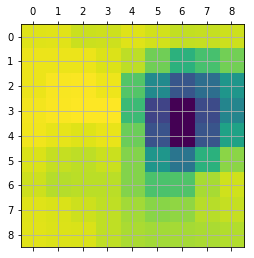

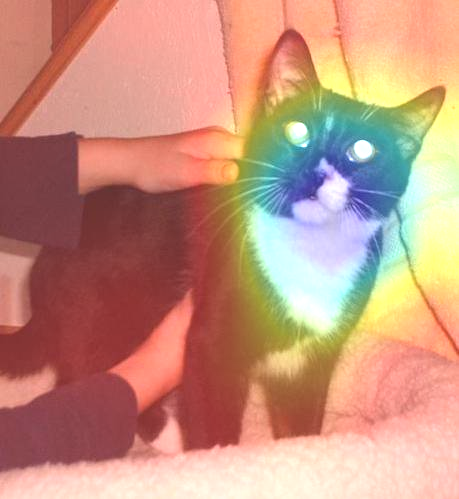

In [0]:
my_process_image(filenames[real_cats[0]])

### A real dog (properly classified)

dogs/dog.2000.jpg


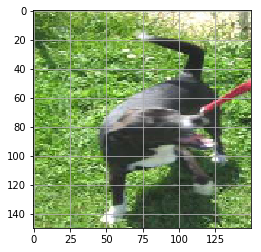

Predicted: [58.299168]


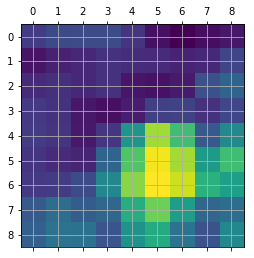

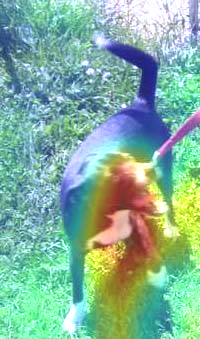

In [0]:
my_process_image(filenames[real_dogs[0]])

### A fake cat (a dog misclassified as a cat)

dogs/dog.2146.jpg


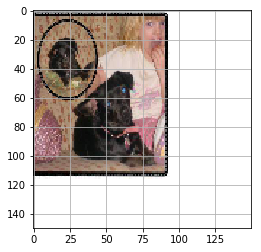

Predicted: [-3.4283168]


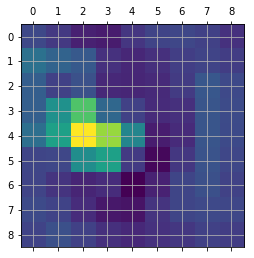

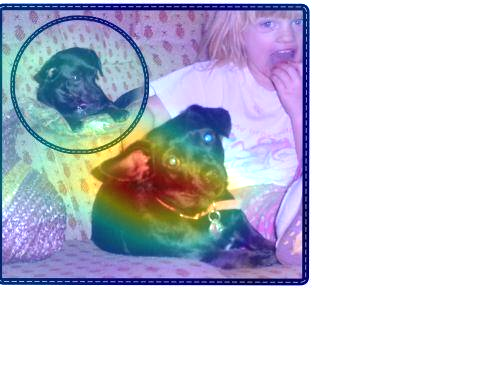

In [0]:
my_process_image(filenames[fake_cats[0]])

### A fake dog (a cat misclassified as a dog)

cats/cat.2061.jpg


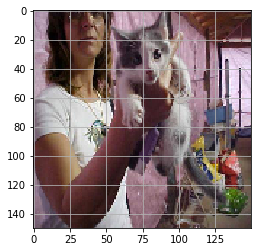

Predicted: [27.085987]


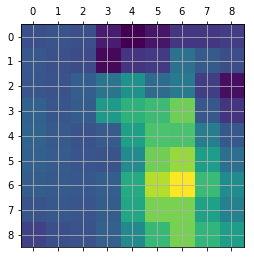

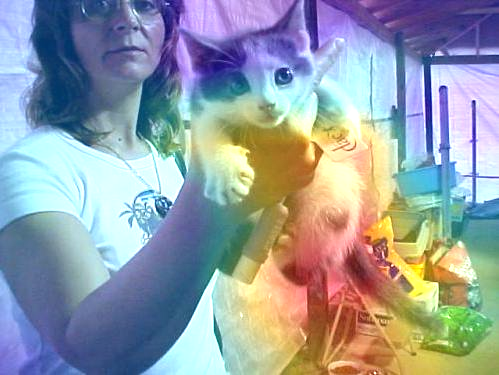

In [0]:
my_process_image(filenames[fake_dogs[0]])